,exposed_(mn),displaced_(k),killed,duration(days)
exposed_(mn),1.00,0.41,0.46,0.66
displaced_(k),0.41,1.00,0.62,0.29
killed,0.46,0.62,1.00,0.50
duration(days),0.66,0.29,0.50,1.00


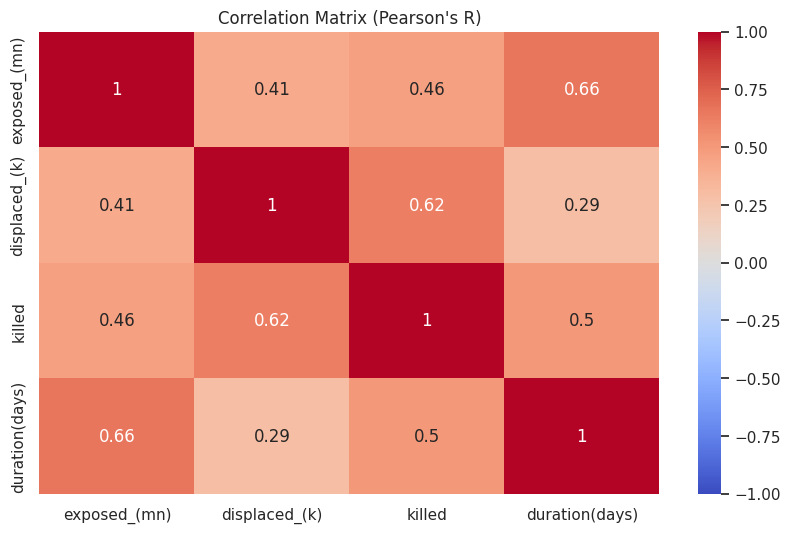

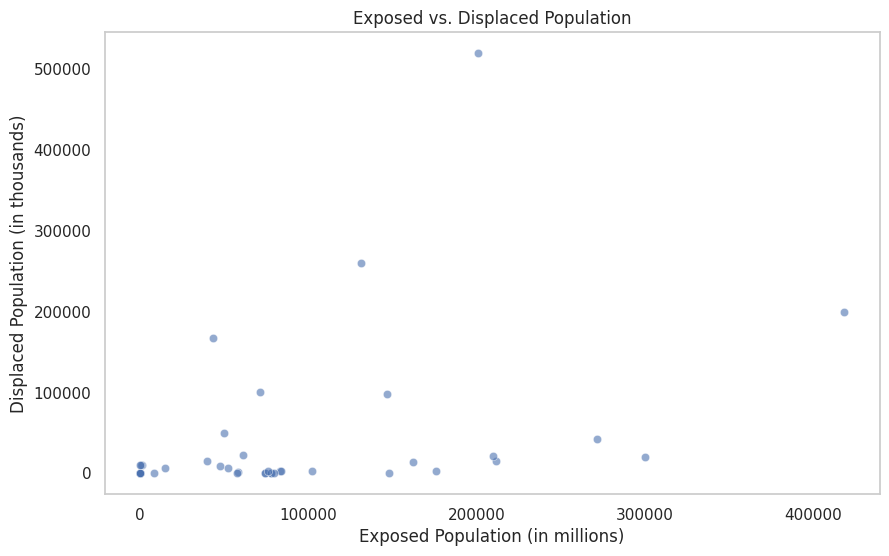

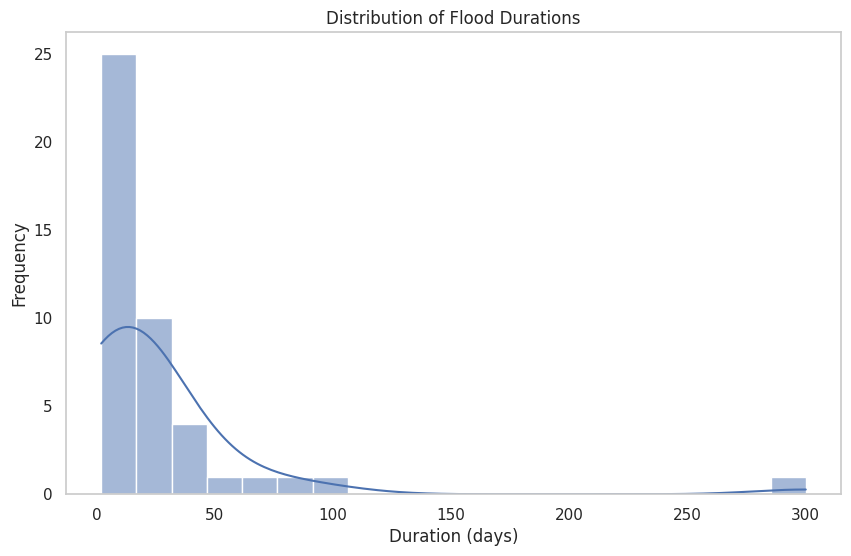

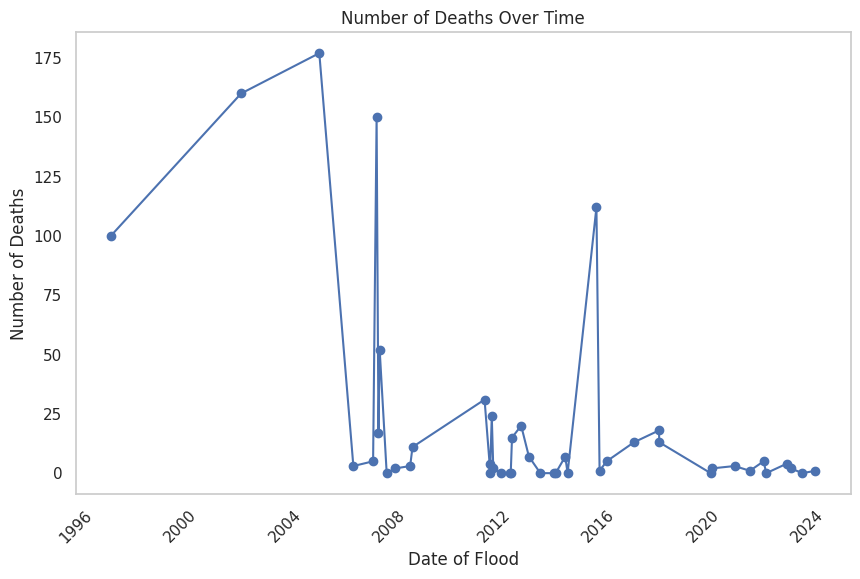

Accuracy: 0.57
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.58      0.88      0.70         8

    accuracy                           0.57        14
   macro avg       0.54      0.52      0.47        14
weighted avg       0.55      0.57      0.51        14



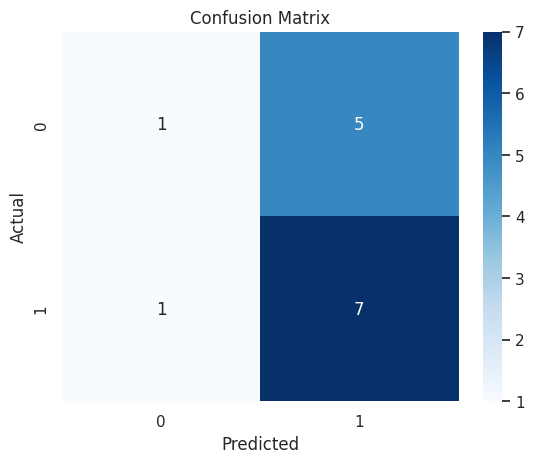

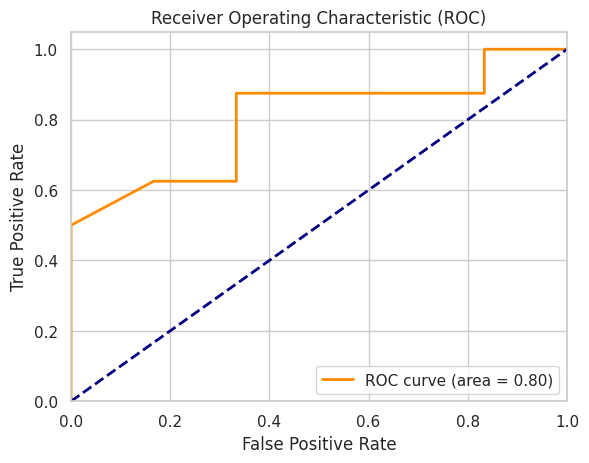

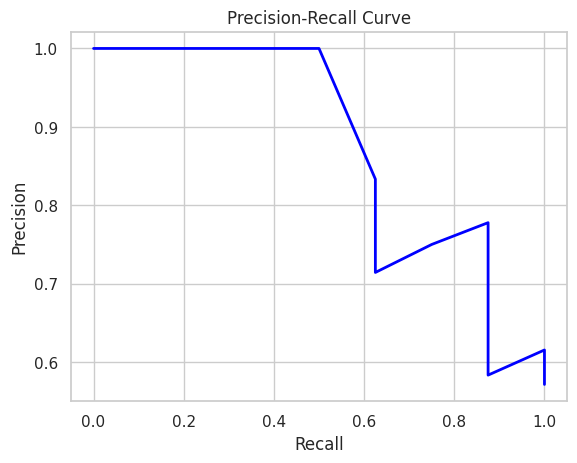

In [10]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Load data
def load_data(filepath):
    """Load flood data from a CSV file."""
    return pd.read_csv(filepath)

# Specify the file path to your cleaned data
filepath = '../data/processed/cleaned_flood_data.csv'
df = load_data(filepath)

# Convert 'flood' column to datetime to avoid including it in numeric analysis
df['flood'] = pd.to_datetime(df['flood'], errors='coerce')

# ---- PART 1: Correlation and Visualizations ---- #

# Generate a table showing Pearson correlation coefficients (R)
def generate_correlation_table(df):
    """Generate a table showing Pearson's R correlation coefficients between numeric variables."""
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    correlation_matrix = numeric_df.corr(method='pearson')
    styled_corr_table = correlation_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)
    display(styled_corr_table)
    return correlation_matrix

# Generate correlation table
correlation_table = generate_correlation_table(df)

# Plot the correlation matrix
def plot_correlation_matrix(correlation_matrix):
    """Plot a heatmap of the correlation matrix."""
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix (Pearson\'s R)')
    plt.show()

plot_correlation_matrix(correlation_table)

# Scatter plot between exposed and displaced population
def plot_exposed_vs_displaced(df):
    """Plot the relationship between exposed and displaced populations."""
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='exposed_(mn)', y='displaced_(k)', alpha=0.6)
    plt.title('Exposed vs. Displaced Population')
    plt.xlabel('Exposed Population (in millions)')
    plt.ylabel('Displaced Population (in thousands)')
    plt.grid()
    plt.show()

plot_exposed_vs_displaced(df)

# Distribution of flood durations
def plot_duration_distribution(df):
    """Plot the distribution of flood durations."""
    plt.figure(figsize=(10, 6))
    sns.histplot(df['duration(days)'], bins=20, kde=True)
    plt.title('Distribution of Flood Durations')
    plt.xlabel('Duration (days)')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

plot_duration_distribution(df)

# Number of deaths over time
def plot_killed_over_time(df):
    """Plot the number of deaths over time."""
    plt.figure(figsize=(10, 6))
    plt.plot(df['flood'], df['killed'], marker='o', linestyle='-')
    plt.title('Number of Deaths Over Time')
    plt.xlabel('Date of Flood')
    plt.ylabel('Number of Deaths')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

plot_killed_over_time(df)

# ---- PART 2: Model Evaluation ---- #

# For simplicity, let's assume we're trying to predict 'killed' as a binary classification
# We will use 'exposed_(mn)', 'displaced_(k)', and 'duration(days)' as features

# Create target and feature columns
X = df[['exposed_(mn)', 'displaced_(k)', 'duration(days)']]
y = (df['killed'] > 0).astype(int)  # Binary classification: 1 if killed > 0, otherwise 0

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a simple model (RandomForestClassifier in this case)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC/Precision-Recall Curve

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# 2. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 3. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 5. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()